In [1]:
#Setup & imports

import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone

# Custom Module Imports
from src.utils import data_loader, evaluation
from src.utils.preprocessing import ohe
from src.utils.training import trees

In [2]:
# Configuration
COHORT_NAME = "mimic_cohort_aplasia_45_days"
DATA_DIR = project_root / "data" / COHORT_NAME
CV_FOLDS_DIR = DATA_DIR / "cv_folds"

# Load Master Data
cohort_path = str(DATA_DIR / f"{COHORT_NAME}.csv.gz")
codes_path  = str(DATA_DIR / f"{COHORT_NAME}_icd_codes_upto.csv.gz")

df_target, df_codes, valid_ids = data_loader.load_processed_data(cohort_path, codes_path)

# Load Fold Files
fold_files = data_loader.get_fold_files(str(CV_FOLDS_DIR))

 Data Loaded. Total Patients in Cohort: 4539


In [3]:
# Feature Engineering
print("Generating Feature Sets (Full, Groups, Combined)...")

# Generate all feature matrices
feature_datasets = ohe.generate_feature_sets(df_codes)

# Align Targets (We grab the index from one of the matrices)
reference_index = feature_datasets['Full Codes'].index
y = df_target.set_index('hadm_id').loc[reference_index, 'label']

# Print Dimensions for verification

for name, df in feature_datasets.items():
    print(f"{name}: {df.shape}")

Generating Feature Sets (Full, Groups, Combined)...
Full Codes: (4539, 6952)
Groups: (4539, 1683)
Combined: (4539, 8635)


In [4]:
# Define Models
models_map = {
    "XGBoost": trees.get_xgboost_model(),
    "RandomForest": trees.get_rf_model(),
    "CatBoost": trees.get_catboost_model()
}

In [5]:
# Cross-Validation Loop

results_data = []

# Feature Sets
for feat_name, X_data in feature_datasets.items():
    print(f"\n--- Processing Features: {feat_name} ---")
    
    # Models
    for model_name, model_template in models_map.items():
        print(f"  Training {model_name}...", end=" ")
        
        # Cross Validation
        avg_scores = evaluation.cross_validate(
            model_template=model_template,
            X_data=X_data,
            y=y,
            fold_files=fold_files,
            load_fold_func=data_loader.load_single_fold,
            train_func=trees.train_model
        )
        
        # Print Summary
        print(f"-> Avg AUC: {avg_scores['AUC']:.4f}")
        
        # Store results
        row = {"Model": model_name, "Features": feat_name}
        row.update(avg_scores)
        results_data.append(row)

print("\n=== Summary Table ===")
summary_df = pd.DataFrame(results_data)
auc_pivot = summary_df.pivot(index="Model", columns="Features", values="AUC")
display(auc_pivot)


--- Processing Features: Full Codes ---
  Training XGBoost... -> Avg AUC: 0.8163
  Training RandomForest... -> Avg AUC: 0.8152
  Training CatBoost... -> Avg AUC: 0.8300

--- Processing Features: Groups ---
  Training XGBoost... -> Avg AUC: 0.8050
  Training RandomForest... -> Avg AUC: 0.8028
  Training CatBoost... -> Avg AUC: 0.8059

--- Processing Features: Combined ---
  Training XGBoost... -> Avg AUC: 0.8256
  Training RandomForest... -> Avg AUC: 0.8169
  Training CatBoost... -> Avg AUC: 0.8323

=== Summary Table ===


Features,Combined,Full Codes,Groups
Model,,,
CatBoost,0.832285,0.829963,0.805899
RandomForest,0.816878,0.815179,0.802832
XGBoost,0.825562,0.816252,0.804960


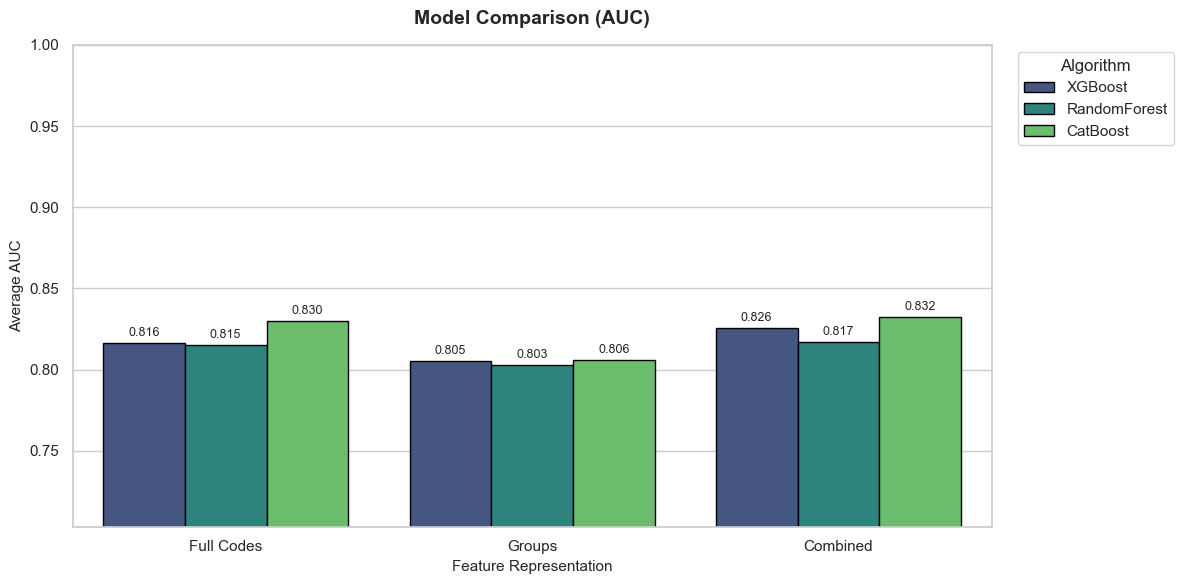

 Best results: CatBoost using Combined (AUC: 0.8323)


In [ ]:
# Plots

#  Visualize 
evaluation.plot_model_comparison(summary_df, metric="AUC")

# Print Best performance
best_row = summary_df.loc[summary_df['AUC'].idxmax()]
print(f" Best results: {best_row['Model']} using {best_row['Features']} (AUC: {best_row['AUC']:.4f})")

--- Generating AGGREGATED Diagnostics for: Combined ---
(This re-runs Cross-Validation to collect predictions for 100% of patients)


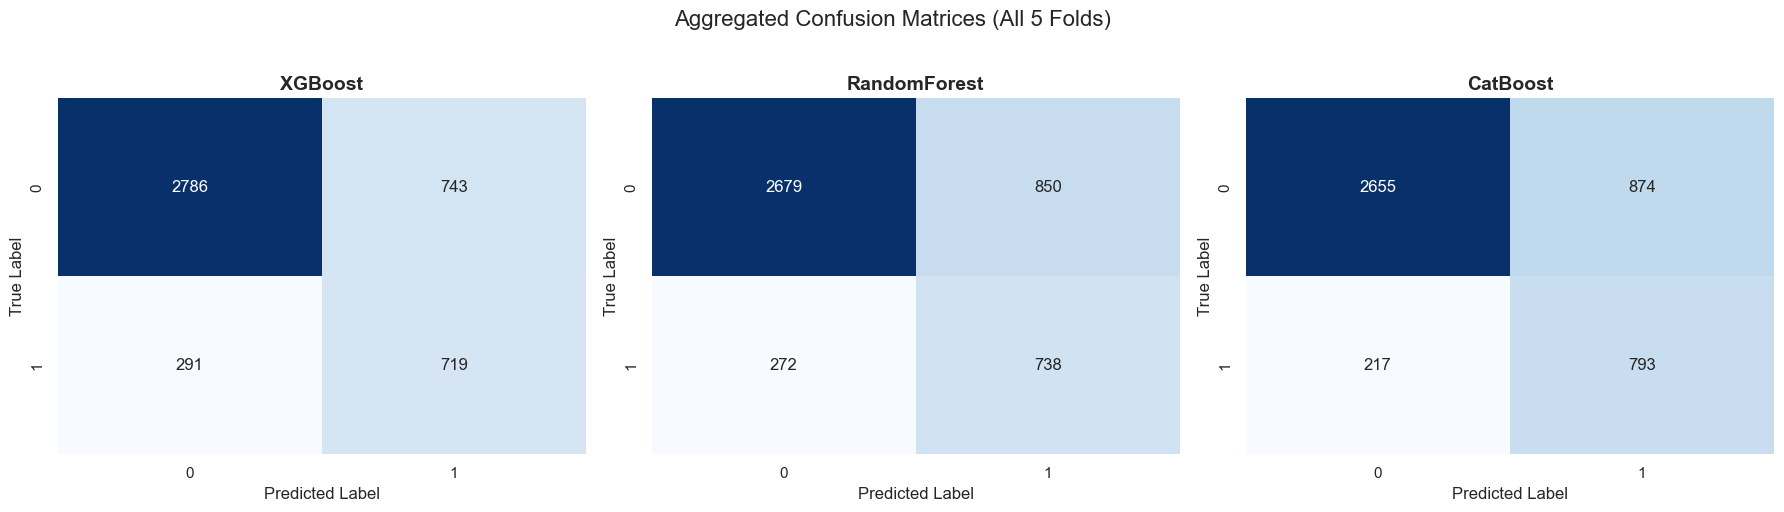

In [7]:
# Aggregated Confusion Matrix

# Use the best representation
target_feature_set = best_row['Features']

print(f"--- Generating AGGREGATED Diagnostics for: {target_feature_set} ---")
print("(This re-runs Cross-Validation to collect predictions for 100% of patients)")

# Select the Data
X_data_full = feature_datasets[target_feature_set]

# Run
evaluation.plot_cv_confusion_matrices(
    models_map=models_map, X_data=X_data_full, y=y, fold_files=fold_files, load_fold_func=data_loader.load_single_fold, train_func=trees.train_model
)